*project proposal*

markdown

In [1]:
library(tidyverse)
library(tidymodels)
library(rvest)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# This cell proceeds downloading and unzipping the data
url_ <- "https://archive.ics.uci.edu/static/public/109/wine.zip"
download.file(url_,"wine.zip")
unzip("wine.zip")

In [3]:
wine_data <- read_delim("wine.data", delim = ",", col_name = FALSE)|>
             mutate(X1 = as_factor(X1))

# column names are copied from the source url https://archive.ics.uci.edu/dataset/109/wine
colnames(wine_data) <- c('class', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 
                         'Nonflavanoid_phenols','Proanthocyanins','Color_intensity', 'Hue','OD280_OD315_of_diluted_wines',
                         'Proline')

# we tried scratch column names directly from the webpage, but it just missed some columns due to unknown reasons,
# and we couldn't fix the issue even after consulting TAs
# webpage <- read_html("https://archive.ics.uci.edu/dataset/109/wine")
# col_data <- html_nodes(webpage, "td:nth-child(1)")
# col_text <- html_text(cell_data)

# colnames(wine_data) <- col_text
wine_data 

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315_of_diluted_wines,Proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [4]:
num_obs <- nrow(wine_data)
wine_data|>
    group_by(class)|>
     summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
# The result shows that the data set has a relatively very balanced distribution of the 3 classes

class,count,percentage
<fct>,<int>,<dbl>
1,59,33.14607
2,71,39.88764
3,48,26.96629


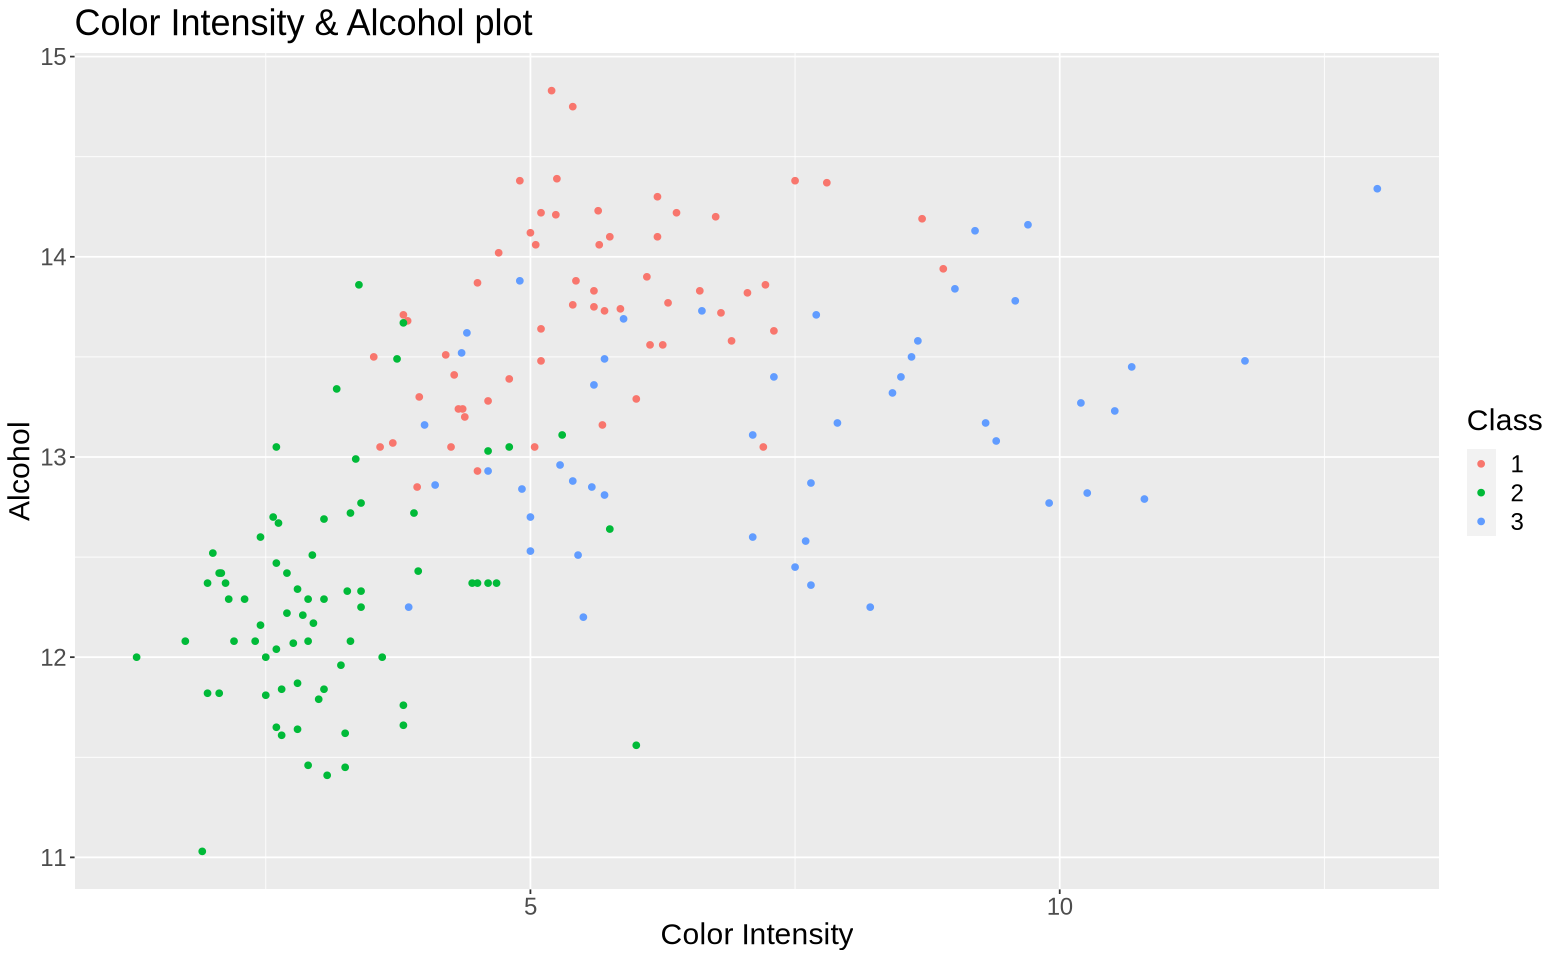

In [5]:
# We plot the color intensity and alcohol to see how class may distribute regarding the two variables
options(repr.plot.width =13 , repr.plot.height = 8)
Color_intensity_Alcohol <- ggplot(wine_data, aes(x = Color_intensity, y = Alcohol, color = class)) +
                           geom_point() +
                           labs(x = "Color Intensity", y = "Alcohol", color = "Class") + 
                           ggtitle("Color Intensity & Alcohol plot") +
                           theme(text = element_text(size = 18))
                           
Color_intensity_Alcohol

In [6]:
# We set the seed to make sure our outcome to be repeatable
set.seed(333)

wine_split <- initial_split(wine_data, prop = 0.75, strata = class)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




[1] "Proline"                      "Flavanoids"                  
[3] "Alcohol"                      "Color_intensity"             
[5] "OD280_OD315_of_diluted_wines"

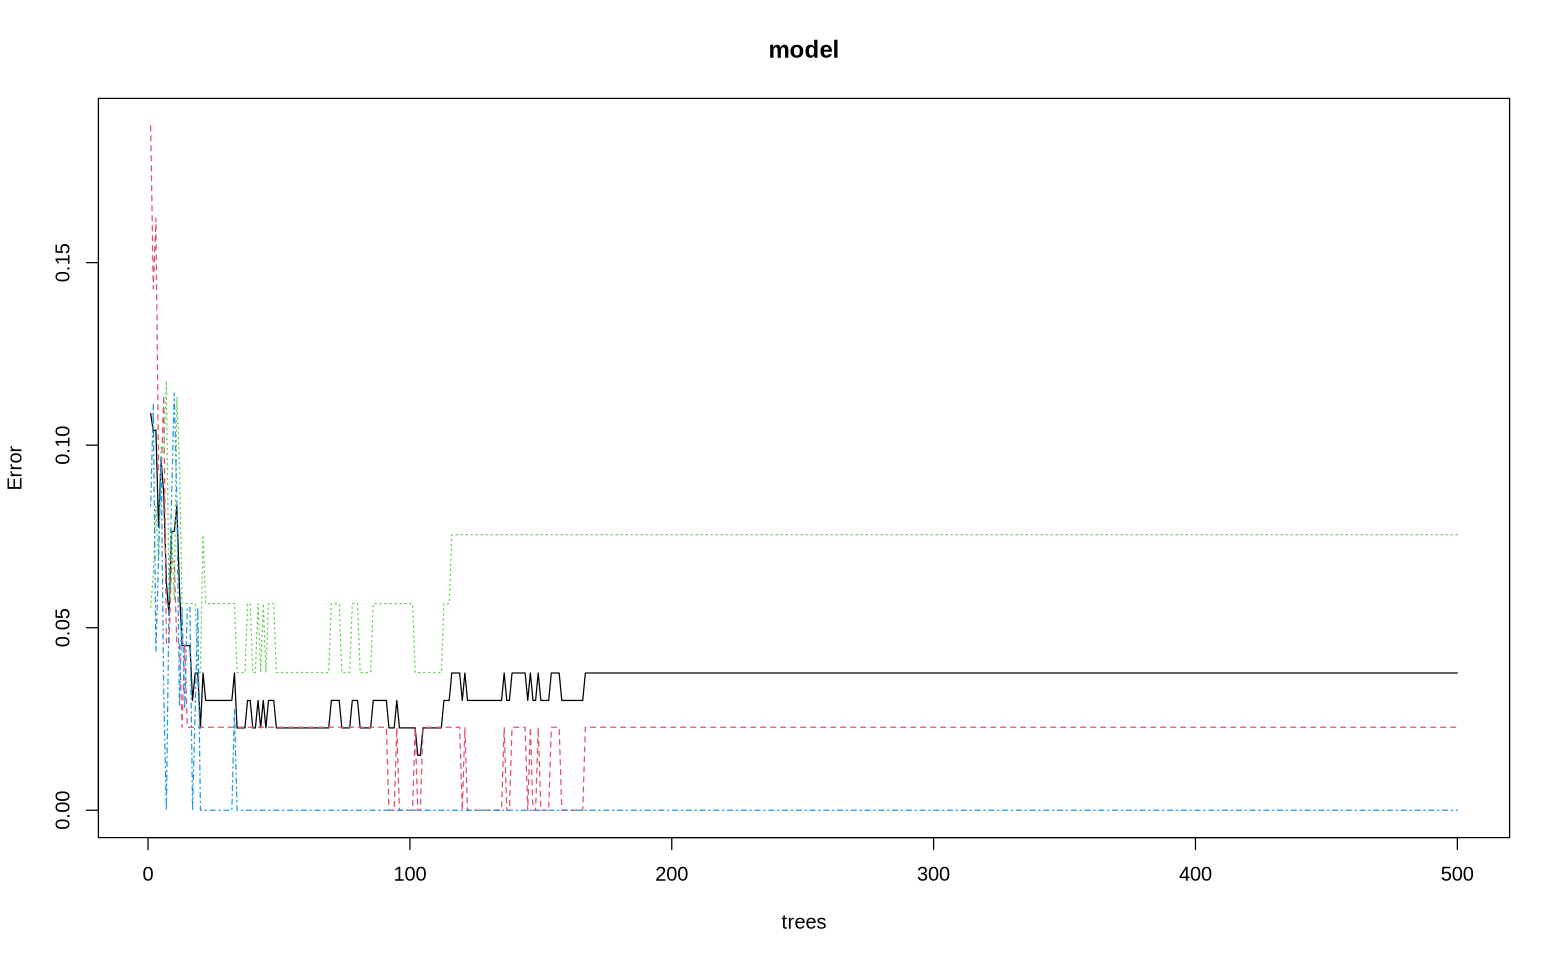

In [7]:
# Using the random forest method to find out the 5 variables that have strongest correlation with the class variable
# inspired by https://www.r-bloggers.com/2021/04/random-forest-in-r/
library(randomForest)
model <- randomForest(class ~ ., data = wine_training)
importance <- importance(model)
important_variables <- data.frame(Variable = row.names(importance), 
                            Importance = importance[, "MeanDecreaseGini"], 
                            row.names = NULL)|>
                 slice_max(importance, n = 5)|>
                 pull(Variable)
important_variables

options(repr.plot.width =13 , repr.plot.height = 8)
plot(model) # The plot shows that our data has very high accuracy

In [8]:
# selected variables that are readily available to normal people
# predictor_variables <-  c('Alcohol', 'Flavanoids', 'Color_intensity', 'Hue') 

wine_training_select <- select(wine_training,class, all_of(important_variables))|>
                 glimpse()

# Using group_by + summarize to see the sample number and percentage of each class and the mean value of each variable for the three classes
num_obs_training <- nrow(wine_training_select)
group_by(wine_training_select, class)|>
summarize(count = n(),
          percentage = n() / num_obs_training * 100,
          across(all_of(important_variables), mean))

Rows: 133
Columns: 6
$ class                        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Proline                      <dbl> 1050, 1185, 1480, 1450, 1045, 1045, 1510,…
$ Flavanoids                   <dbl> 2.76, 3.24, 3.49, 3.39, 2.98, 3.15, 3.32,…
$ Alcohol                      <dbl> 13.20, 13.16, 14.37, 14.20, 14.83, 13.86,…
$ Color_intensity              <dbl> 4.38, 5.68, 7.80, 6.75, 5.20, 7.22, 5.75,…
$ OD280_OD315_of_diluted_wines <dbl> 3.40, 3.17, 3.45, 2.85, 2.85, 3.55, 3.17,…


class,count,percentage,Proline,Flavanoids,Alcohol,Color_intensity,OD280_OD315_of_diluted_wines
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,44,33.08271,1115.4545,3.0172727,13.70568,5.611818,3.110227
2,53,39.84962,510.4906,2.1288679,12.16642,3.132642,2.784906
3,36,27.06767,629.4444,0.7563889,13.07722,7.530833,1.643611


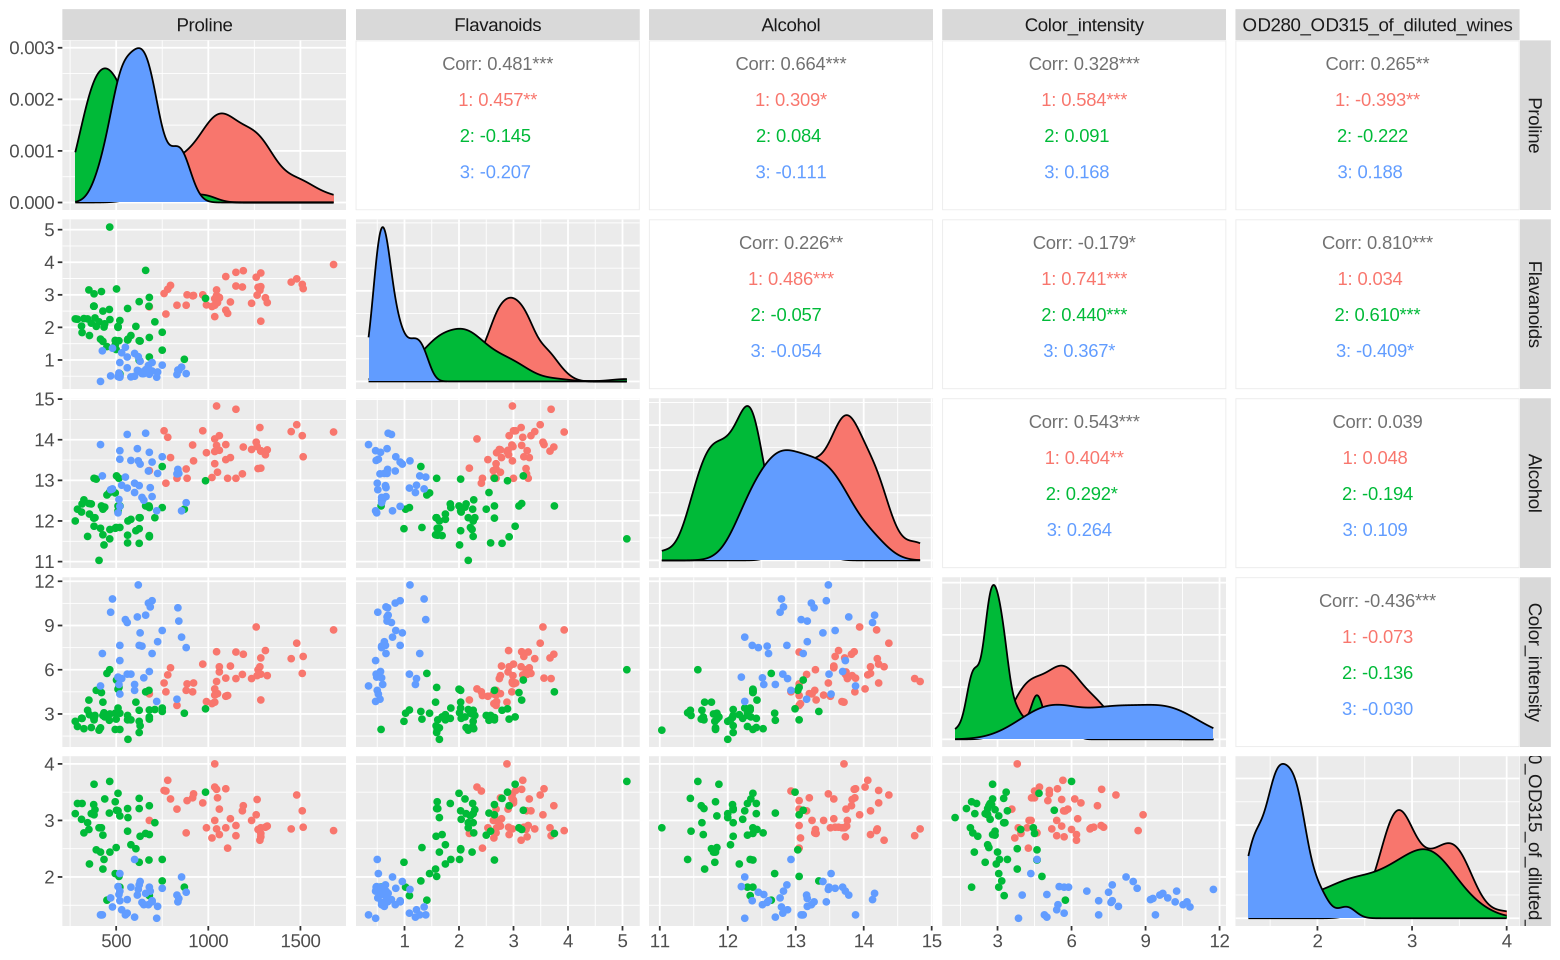

In [9]:
options(repr.plot.width =13 , repr.plot.height = 8) 

# we use the scatter matrix to show the distribution of classes and correlation of our selected variables
ggpairs(wine_training_select, columns = important_variables, ggplot2::aes(colour=class)) + theme(text = element_text(size = 14))

**Methodology***